### Importing the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pil
import skimage as im
import amglib.readers as io
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed
from skimage.morphology import binary_erosion as erode
from skimage.morphology import binary_dilation as dilate
from skimage.morphology import disk
from skimage.morphology import h_maxima
import skimage.morphology.greyreconstruct as gr
from skimage.morphology import label
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import matplotlib.colors as colors
from skimage.color      import hsv2rgb, rgb2hsv
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

%matplotlib inline
#%matplotlib widget

import importlib
importlib.reload(io)

C:\Users\kaestner\git\CBCTCalibration\amglib\imageutils.py:8: FutureWarning: Importing from skimage.morphology.greyreconstruct is deprecated. Please import from skimage.morphology instead.
  import skimage.morphology.greyreconstruct as rec


<module 'amglib.readers' from 'C:\\Users\\kaestner\\git\\CBCTCalibration\\amglib\\readers.py'>

### Importing Datapath where the images are stored

In [2]:
datapath="E:/Kaestner/P20200166Cramer/02_CBCTCal/"

In [46]:
dc=io.read_images(datapath+'dc_{:05}.fits',first=1,last=10,averageStack=True,average='mean');
ob=io.read_images(datapath+'ob_{:05}.fits',first=1,last=10,averageStack=True,average='mean');
cal=io.read_images(datapath+'cbctcal_{:05}.fits',first=1,last=360,stride=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

### Normalize

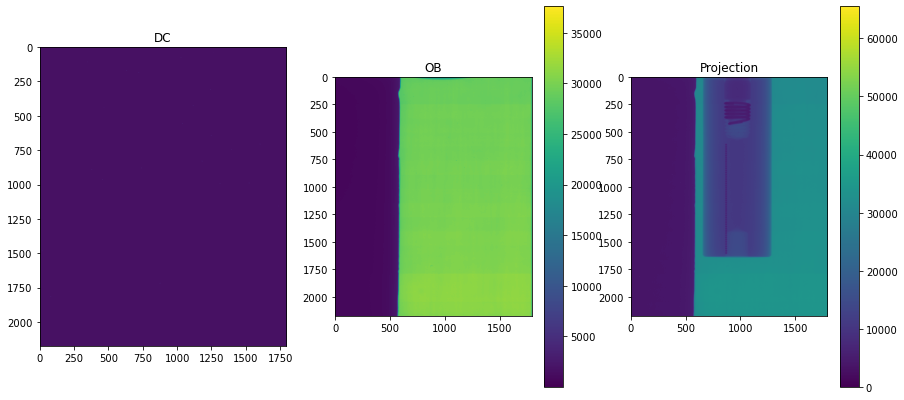

In [47]:
fig, ax = plt.subplots(1,3,figsize=(15,7))
ax=ax.ravel()
ax[0].imshow(dc)
ax[0].set_title('DC')
a1=ax[1].imshow(ob1)
fig.colorbar(a1,ax=ax[1])
ax[1].set_title('OB')
a2=ax[2].imshow(cal[1,:,:]) #,vmin=0.0,vmax=10000)
fig.colorbar(a2,ax=ax[2])
ax[2].set_title('Projection');

In [48]:
def normalizeData(img,ob,dc) :
    ob=ob-dc
    ob[ob<1]=1
    lcal=img.copy();
    for idx in np.arange(0, img.shape[0]):
        tmp=(img[idx,:,:]-dc)
        tmp[tmp<=0]=1
        lcal[idx,:,:]=(tmp/ob)
    lcal=-np.log(lcal)
    
    return lcal

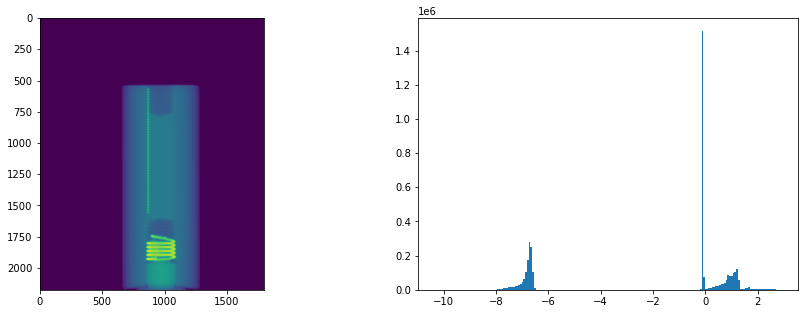

In [64]:
lcal=normalizeData(cal,ob1,dc)
flipProjection = True
if flipProjection : 
    lcal = lcal[:,::-1,:]
    
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(lcal[1],vmin=0,vmax=3)
ax[1].hist(lcal[1].ravel(),bins=200);


### Removing unwanted elements from the image - optional depending on how much extra background is captured

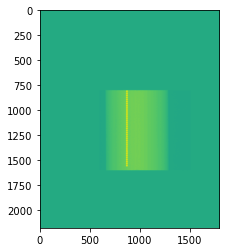

In [74]:
new_lcal=lcal.copy()
new_lcal[:,:,1500:]=0
new_lcal[:,:,:590]=0
new_lcal[:,1600:]=0
new_lcal[:,:800]=0

plt.imshow(new_lcal[1,:,:])

In [75]:
lcal=new_lcal

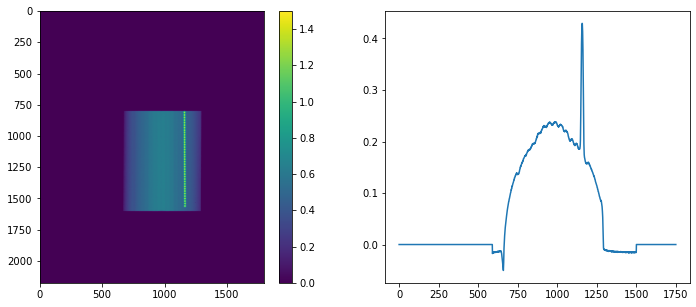

In [76]:
idx=10
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.imshow(lcal[idx,:,:],vmin=0,vmax=1.5)
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(lcal[idx,:,:].mean(axis=0)[:1750])

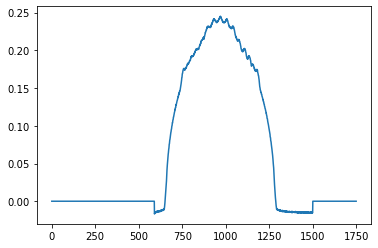

In [77]:
baseline = lcal.mean(axis=0).mean(axis=0)
baseline = baseline.reshape(1,baseline.shape[0])
plt.plot(baseline.ravel()[:1750])

In [78]:
print(lcal.shape)

(36, 2176, 1792)


### Removing Baseline

In [79]:
def removeBaseline(img) :
    img=img[:,:,0:1750]
    baseline = img.mean(axis=0).mean(axis=0)
    baseline = baseline.reshape(1,baseline.shape[0])

    b2=np.matmul(np.ones([img.shape[1],1]),baseline)
    res=img;
    print(b2.shape,res.shape)
    for idx in np.arange(0,img.shape[0]) :
        res[idx,:,:]=res[idx,:,:]-b2
    return res

bcal=removeBaseline(lcal)

(2176, 1750) (36, 2176, 1750)


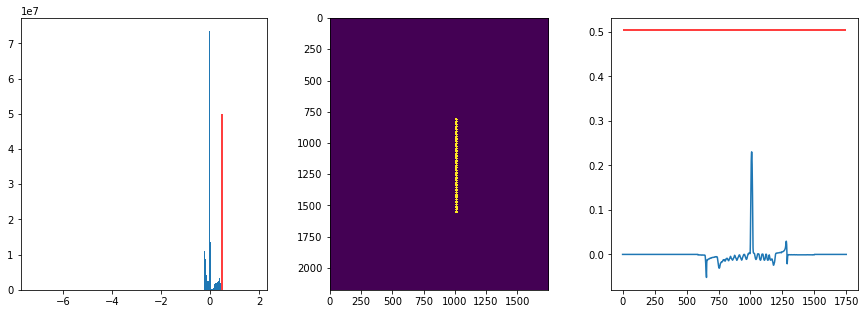

In [80]:
idx=5
m = bcal.mean()
s = bcal.std()
k=3.3
fig,ax=plt.subplots(1,3,figsize=[15,5])
ax[0].hist(bcal.ravel(),bins=256)
ax[0].vlines(m+k*s,ymin=0,ymax=5e7,color='r')
im=ax[1].imshow(m+k*s < bcal[idx,:,:],interpolation='None')
ax[2].plot(bcal[idx,:,:].mean(axis=0));
ax[2].hlines(m+k*s,xmin=0, xmax=bcal.shape[2],color='r');

In [81]:
def thresholdBBs(img,k) :
    s=bcal.std()
    m=bcal.mean()
    
    return (m+k*s)< img

tcal=thresholdBBs(bcal,3.3)

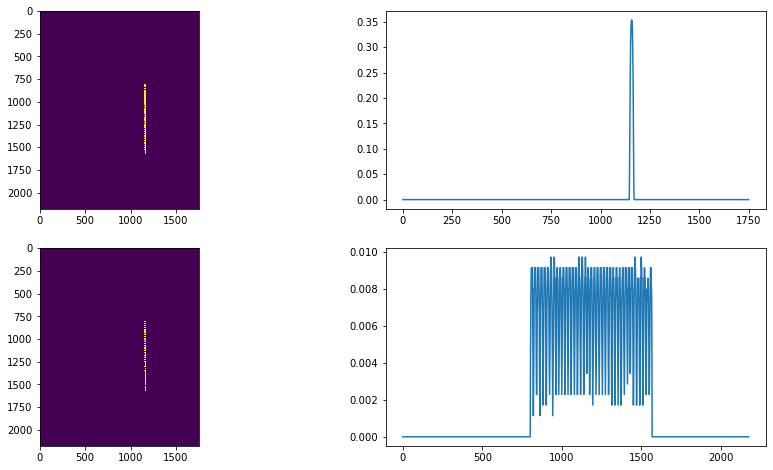

In [82]:
from skimage.transform import rescale, resize, downscale_local_mean
idx=10
fig,ax = plt.subplots(2,2,figsize=(15,8))
ax=ax.ravel()
ax[0].imshow(tcal[idx,:,:],interpolation='None')
ax[1].plot(tcal[idx,:,:].mean(axis=0))
ecal = erode(tcal[idx,:,:],disk(2))
ax[2].imshow(ecal,interpolation='None')
ax[3].plot(ecal.mean(axis=1))

### Watershed Segmentation

In [83]:
def min_impose(dimg,markers) :
    fm=markers.copy()
    fm[markers != 0] = 0
    fm[markers == 0] = dimg.max()
    dimg2 = np.minimum(fm,dimg+1)
    res   = gr.reconstruction(fm,dimg2,method='erosion')
    
    return res

def randomCM(N, low=0.2, high=1.0,seed=42, bg=0) :
    np.random.seed(seed=seed)
    clist=np.random.uniform(low=low,high=high,size=[N,3]); 
    m = ortho_group.rvs(dim=3)
    if bg is not None : 
        clist[0,:]=bg;
        
    rmap = ListedColormap(clist)
    
    return rmap

def goldenCM(N,increment=1.0,s=0.5,v=0.7,bg=0) :
    phi= 0.5*(np.sqrt(5)-1)
    
    hsv = np.zeros([N,3]);
    hsv[:, 0] = increment*phi*np.linspace(0,N-1,N)-np.floor(increment*phi*np.linspace(0,N-1,N))
    hsv[:, 1] = s
    hsv[:, 2] = v
    rgb = hsv2rgb(hsv)
    if bg is not None : rgb[0,:]=bg    
    cm = ListedColormap(rgb) 
    return cm

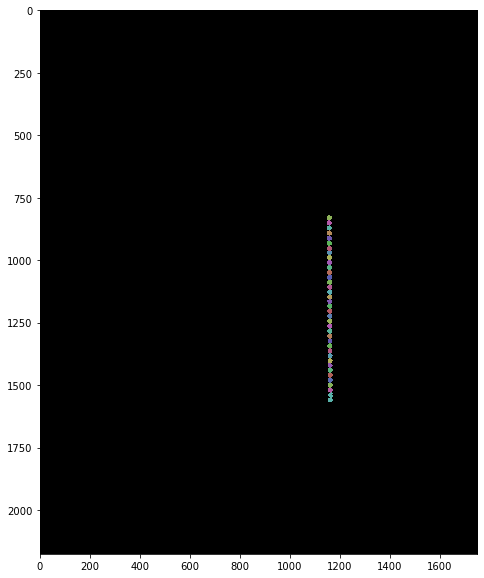

In [84]:
from skimage.measure import label, regionprops, regionprops_table

img = tcal[idx,:,:]
distance = ndi.distance_transform_edt(img)

h=2
localmax = h_maxima(distance,h)
rdmap    = distance.max()-distance
labels   = label(localmax)
ws1 = watershed(min_impose(rdmap,labels),labels,mask=img)
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(ws1,interpolation='None',cmap=goldenCM(labels.max()))

### Figuring out beads

In [85]:
rp = regionprops_table(ws1,properties=('area','centroid'))
cog=np.zeros([rp['centroid-0'].shape[0],2])
cog[:,0]=rp['centroid-0']
cog[:,1]=rp['centroid-1']

In [86]:
def findBeadsWS(img, selem= disk(3),h=2) :
    distance = ndi.distance_transform_edt(erode(img,selem))

    localmax = h_maxima(distance,h)
    rdmap    = distance.max()-distance
    labels   = label(localmax)
    ws1 = watershed(min_impose(rdmap,labels),labels,mask=img)
    
    rp = regionprops_table(ws1,properties=('area','centroid'))
       
    cog=np.zeros([rp['centroid-0'].shape[0],2])
    cog[:,0]=rp['centroid-0']
    cog[:,1]=rp['centroid-1']
    return cog

def findBeads(img, selem, c = 1.96) :
    eimg = erode(img,selem)
     
    labels = label(eimg)
    ll = {}
    for i in np.arange(0, labels.max()+1):
        a = np.sum(labels==i)
        if (a<np.prod(img.shape)/2) :
            ll[i]=a
    m = np.mean(list(ll.values()))
    s = np.std(list(ll.values()))
    
    cog=[]
    for lbl in ll :
        selection=np.argwhere(labels==lbl)
        if ((len(selection)<m+c*s) and (m-c*s<len(selection))):
            cog.append(selection.mean(axis=0))
       
    cog=np.asarray(cog)
    return cog


def buildBeadList(img,selem=disk(12),c=1.96) :
    beadlist = []

    for idx in np.arange(0, img.shape[2]) :
        cog=findBeadsWS(img[:,:,idx],selem,c)
        beadlist.append(cog)

    return beadlist

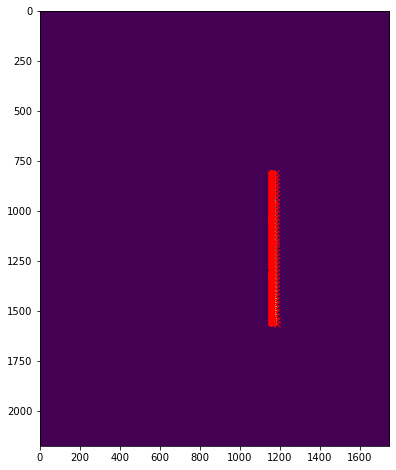

In [87]:
idx=11
c=4
cog=findBeadsWS(tcal[idx,:,:])

plt.figure(figsize=[12,8])
plt.imshow(tcal[idx,:,:])

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')

cog1=findBeadsWS(tcal[idx+1,:,:])
plt.plot(cog1[:,1]-1,cog1[:,0]-1,'rx')

cog2=findBeadsWS(tcal[idx-1,:,:])
plt.plot(cog2[:,1]-1,cog2[:,0]-1,'ro')

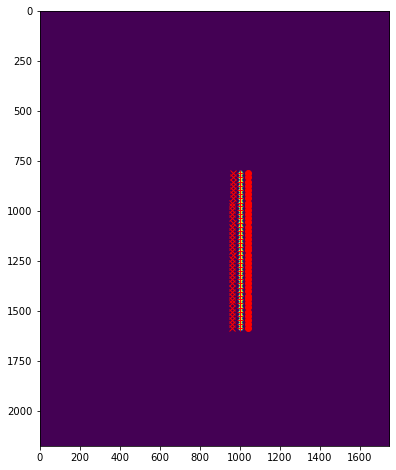

In [88]:
idx=21
c=4
cog=findBeadsWS(tcal[idx,:,:])

plt.figure(figsize=[12,8])
plt.imshow(tcal[idx,:,:])

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')

cog1=findBeadsWS(tcal[idx+1,:,:])
plt.plot(cog1[:,1]-1,cog1[:,0]-1,'rx')

cog2=findBeadsWS(tcal[idx-1,:,:])
plt.plot(cog2[:,1]-1,cog2[:,0]-1,'ro')

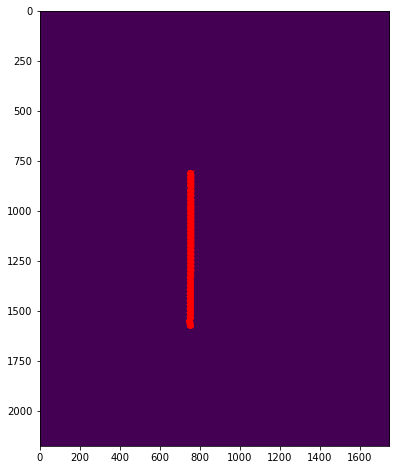

In [89]:
idx=31
c=k
cog=findBeadsWS(tcal[idx,:,:])

plt.figure(figsize=[12,8])
plt.imshow(tcal[idx,:,:])

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')

cog1=findBeadsWS(tcal[idx+1,:,:])
plt.plot(cog1[:,1]-1,cog1[:,0]-1,'rx')

cog2=findBeadsWS(tcal[idx-1,:,:])
plt.plot(cog2[:,1]-1,cog2[:,0]-1,'ro')

### Plotting Corresponding ellipses

In [90]:
def medianDistance(cog) :
    return np.median(np.diff(cog[:,0]))

def itemList(cog) :
    d=medianDistance(cog)
    idx=np.floor((cog[:,0]-cog[0,0])/d+0.5).astype(int)
    
    idxList={}
    for (i,c) in zip(idx,cog) :
        idxList[i]=c
        
    return idxList

def pruneEllipse(e) :
    pe = 1
    
def identifyEllipses(img,selem,c) :
    N=img.shape[0]
    ellipses = {}
        
    for proj in tqdm(np.arange(0,N)) :
        cog = findBeads(img[proj,:,:])
        cogIdx = itemList(cog)
        for idx in cogIdx :
            if idx in ellipses :
                ellipses[idx] = np.vstack([ellipses[idx], cogIdx[idx]])
            else :
                ellipses[idx] = cogIdx[idx]
        
    
    return ellipses

def identifyEllipses2(img,selem) :
    N=img.shape[0]
    ellipses = []
    params=[]
    cog_allbeads=[]    
    beads = []
    for proj in tqdm(np.arange(0,N)) :
        cog = findBeadsWS(img[proj,:,:])
        beads.append(cog)


    for idx in range(len(min(beads,key=len))):
        ellipse = []
        for p in range(N) :
            ellipse.append(beads[p][idx,:].tolist())
        ellipses.append(np.array(ellipse))
        ell = EllipseModel()
        a_ellipse = np.array(ellipse)
        ell.estimate(a_ellipse)
        if ell.params==None:
            continue
        cog_onebead=[]
        for p in range(N) :
            cog_onebead.append(beads[p][idx,:])
        cog_allbeads.append(cog_onebead)
        xc, yc, a, b, theta = ell.params
        print("ID Number = ", idx)
        print("center = ",  (xc, yc))
        print("angle of rotation = ",  theta)
        print("axes = ", (a,b))
        x=a_ellipse[:,0]
        y=a_ellipse[:,1]
        fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
        axs[0].scatter(x, y)

        axs[1].scatter(x, y)
        axs[1].scatter(xc, yc, color='red', s=100)
#         axs[1].set_xlim(x.min(), x.max())
#         axs[1].set_ylim(y.min(), y.max())

        ell_patch = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')

        axs[1].add_patch(ell_patch)
        plt.show()
        params.append([xc,yc,a,b,theta])
    return params,cog_allbeads

  0%|          | 0/36 [00:00<?, ?it/s]

ID Number =  3
center =  (873.431436359971, 972.4398514962918)
angle of rotation =  1.5709637708453914
axes =  (204.54561010458528, 2.859896853370456)


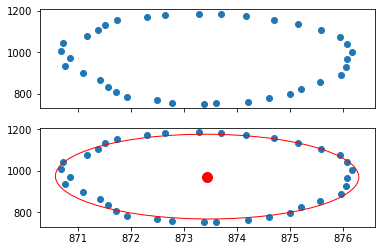

ID Number =  4
center =  (893.7786459767178, 969.161775521024)
angle of rotation =  0.00038845193168664753
axes =  (2.820606894327114, 247.42343097509095)


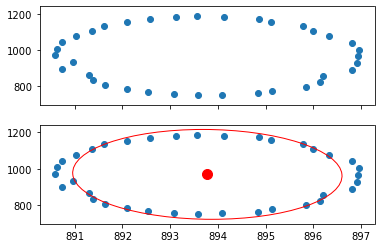

ID Number =  5
center =  (914.2808390270939, 968.4753823967158)
angle of rotation =  1.5712325543168562
axes =  (215.96323423605452, 3.6014114361505203)


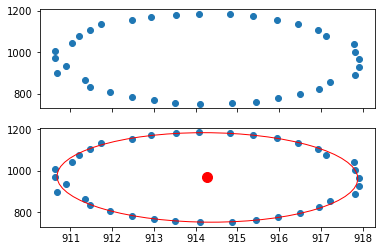

ID Number =  6
center =  (934.8188813952617, 970.5318328016093)
angle of rotation =  0.00046669630173124167
axes =  (4.072888676379167, 215.68995247894378)


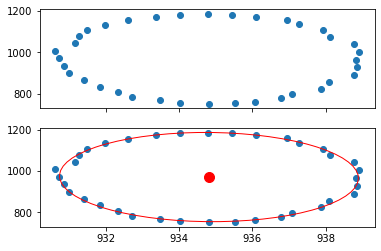

ID Number =  7
center =  (955.2792396220003, 967.9627434760881)
angle of rotation =  0.0004227382719271628
axes =  (4.601483756064545, 212.66029275243534)


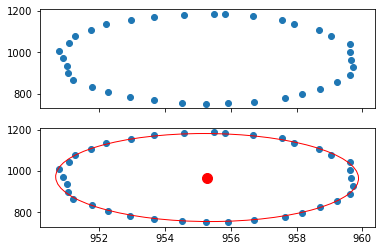

ID Number =  8
center =  (973.9691310736348, 970.7618424880608)
angle of rotation =  1.5711191830346798
axes =  (210.50234526021265, 5.061907067824218)


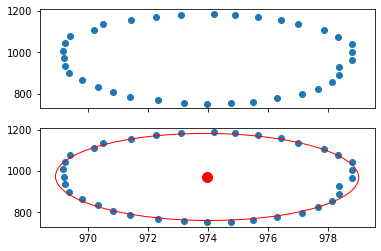

ID Number =  9
center =  (992.9386389587362, 969.5208452125345)
angle of rotation =  1.5710214052938283
axes =  (219.5990310858603, 5.302297828487232)


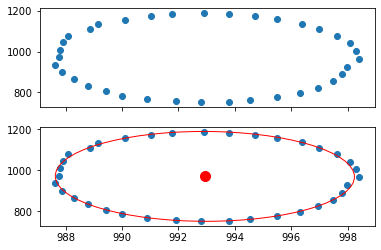

ID Number =  10
center =  (1012.6744868649486, 968.1840940192407)
angle of rotation =  1.571064131246081
axes =  (217.50806934383465, 5.861223141911929)


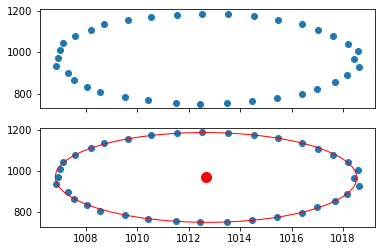

ID Number =  11
center =  (1032.7385064893595, 969.638638298044)
angle of rotation =  0.0004907947848396682
axes =  (6.351103158661907, 216.79204691173692)


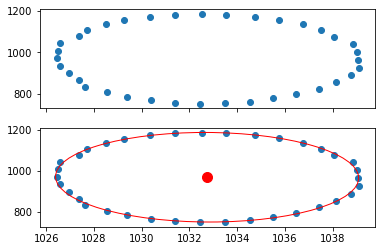

ID Number =  12
center =  (1052.7778797977219, 967.826257014597)
angle of rotation =  1.5711675802523628
axes =  (217.42750959512074, 6.760036823240462)


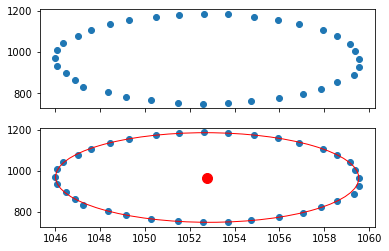

ID Number =  13
center =  (1072.4406172368633, 967.3009051317517)
angle of rotation =  0.0002994995677854201
axes =  (7.23130012181769, 216.3914558813138)


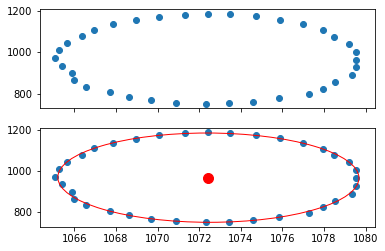

ID Number =  14
center =  (1092.343988288354, 968.6576510298646)
angle of rotation =  0.00021958908716215473
axes =  (7.679542276531225, 216.61335544500403)


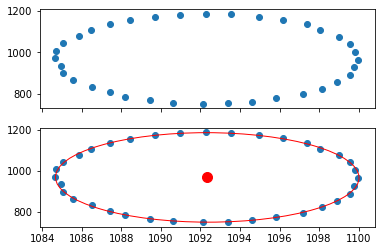

ID Number =  15
center =  (1112.3828343593298, 969.2174794017789)
angle of rotation =  0.0003045771739855102
axes =  (8.106592350659614, 217.59519616626574)


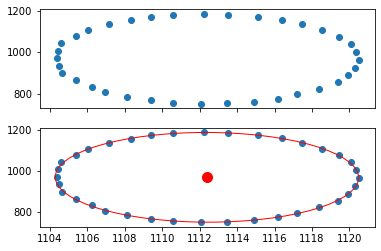

ID Number =  16
center =  (1132.569665140308, 968.2751568517688)
angle of rotation =  1.5709389018420854
axes =  (218.1128267392817, 8.573385030395448)


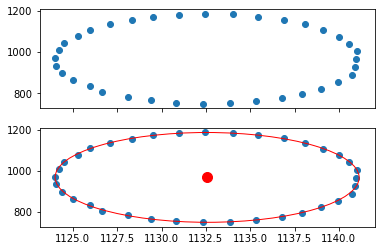

ID Number =  17
center =  (1152.5063477643203, 966.782264945898)
angle of rotation =  -3.4095942445082984e-05
axes =  (9.104956680254897, 217.8489614478717)


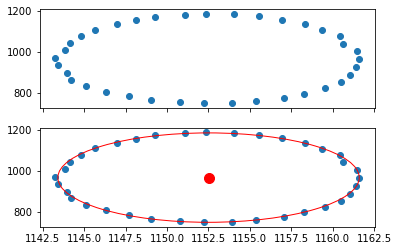

ID Number =  18
center =  (1170.9880715566912, 968.7033759954296)
angle of rotation =  0.00011273100324470235
axes =  (9.497209231763856, 218.0647796138474)


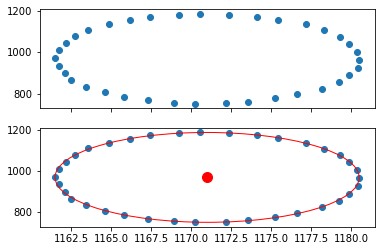

ID Number =  19
center =  (1189.961957452606, 968.8575380619183)
angle of rotation =  0.00019598767864877583
axes =  (9.934436081914873, 217.94184452323296)


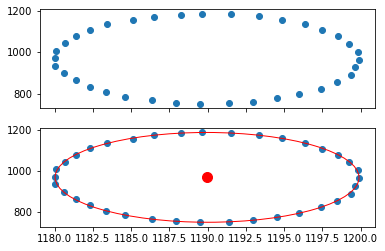

ID Number =  20
center =  (1209.9345727633593, 969.3333798969697)
angle of rotation =  1.5709554115096929
axes =  (217.99613964700816, 10.421642056003822)


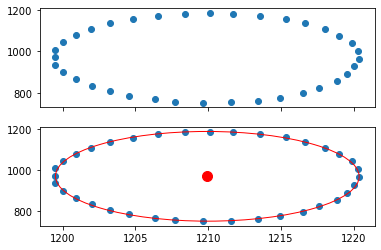

ID Number =  21
center =  (1230.1340928324257, 969.0744074939269)
angle of rotation =  0.00011545220970045392
axes =  (10.87874390104966, 218.24616908889024)


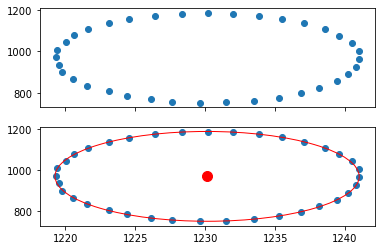

ID Number =  22
center =  (1250.2940203347398, 969.0359788922977)
angle of rotation =  3.1211213619734935e-05
axes =  (11.323817084925395, 218.49514915178776)


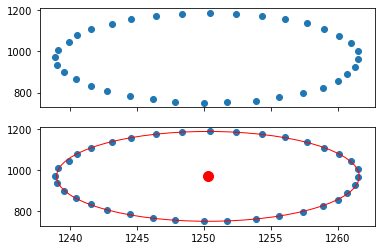

ID Number =  23
center =  (1270.2974802504505, 968.8833430830499)
angle of rotation =  -3.4592227307066655e-06
axes =  (11.788731694857473, 218.5698321858515)


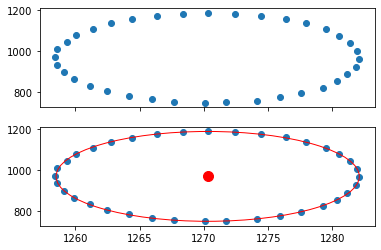

ID Number =  24
center =  (1290.3876491644246, 968.56252360119)
angle of rotation =  1.5706814557981592
axes =  (218.38556860433343, 12.266832213778356)


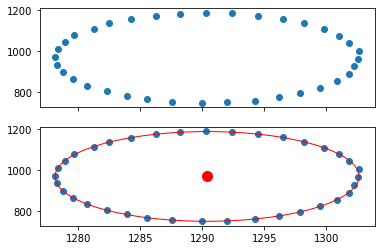

ID Number =  25
center =  (1310.7139427458992, 968.5284078133445)
angle of rotation =  -0.00025018953473832285
axes =  (12.716731632608571, 218.97798032968055)


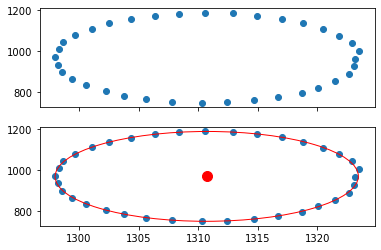

ID Number =  26
center =  (1330.692159002604, 969.0458163050656)
angle of rotation =  1.5707910846565662
axes =  (219.1626341467186, 13.169360415069791)


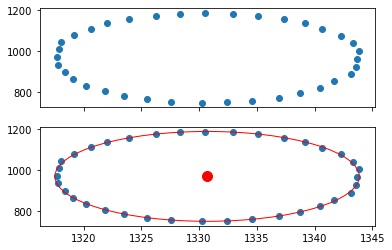

ID Number =  27
center =  (1350.6202751583307, 968.5035319320516)
angle of rotation =  1.8863352634812307e-05
axes =  (13.660074911246051, 218.80077837824876)


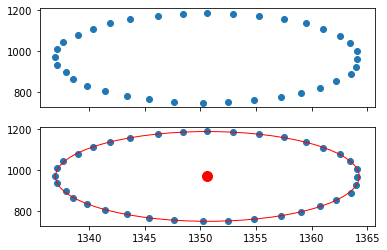

ID Number =  28
center =  (1370.5447846464065, 968.4973305401185)
angle of rotation =  5.433589413927183e-05
axes =  (14.149988657974955, 218.78837784888955)


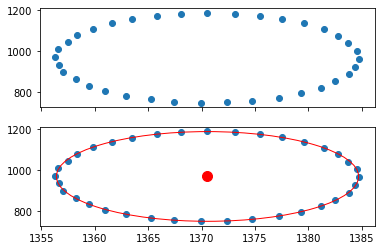

ID Number =  29
center =  (1390.4696198533745, 968.9332386471388)
angle of rotation =  8.993359038375612e-05
axes =  (14.645120320564361, 219.3257232613208)


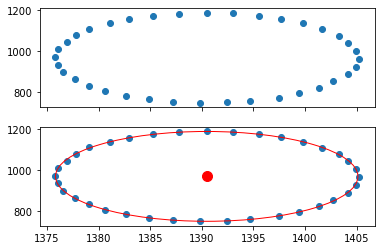

ID Number =  30
center =  (1410.334798241689, 969.0083532021991)
angle of rotation =  -7.942421279077754e-05
axes =  (15.085943155045062, 219.59538807770593)


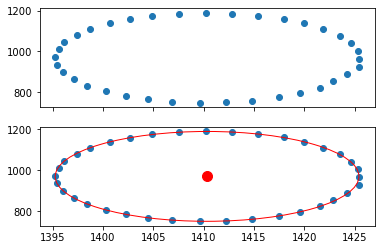

ID Number =  31
center =  (1429.2390189273117, 969.5608386038703)
angle of rotation =  1.5703744666652562
axes =  (218.60206297794517, 15.483229906976652)


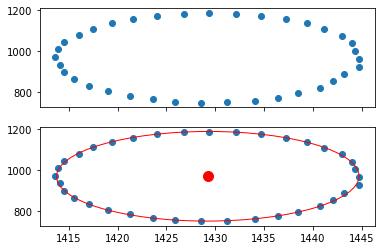

ID Number =  32
center =  (1448.2992044732578, 968.7172746934333)
angle of rotation =  -0.00012404267240187205
axes =  (15.947431087141988, 219.38261123362048)


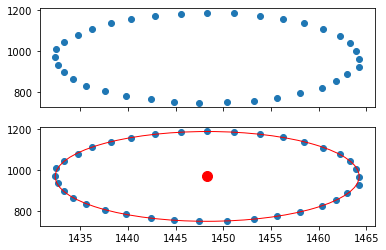

ID Number =  33
center =  (1468.6315039906724, 968.8861264058374)
angle of rotation =  -0.0001587081629746112
axes =  (16.42589755060245, 219.5443927269299)


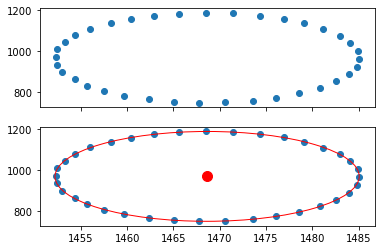

ID Number =  34
center =  (1488.798175366239, 968.786820752459)
angle of rotation =  1.5706467337490642
axes =  (219.69355720383683, 16.92297288171483)


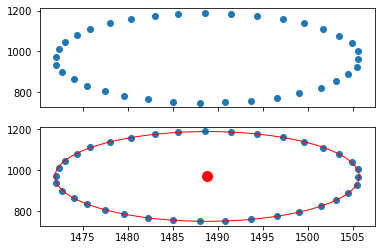

ID Number =  35
center =  (1508.9835044838217, 968.9537779527274)
angle of rotation =  1.5705377080258345
axes =  (219.83594356197125, 17.40940711497507)


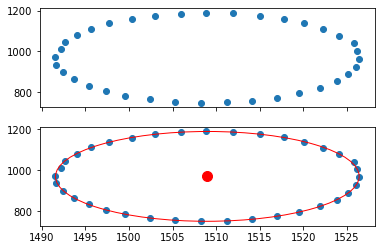

ID Number =  36
center =  (1529.2032181843142, 968.9692658252573)
angle of rotation =  1.5703457631500604
axes =  (219.86435941941008, 17.86040428250631)


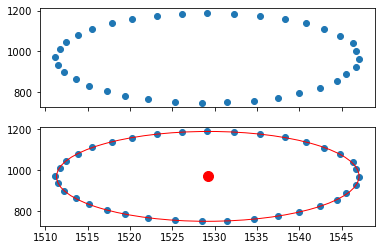

ID Number =  37
center =  (1549.0785736836772, 968.6498868187957)
angle of rotation =  1.5704502432712897
axes =  (221.2521559663117, 18.438468163239573)


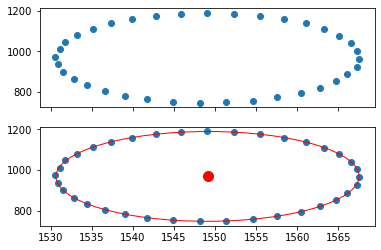

ID Number =  38
center =  (1569.0591060756778, 969.0493417145562)
angle of rotation =  1.5705475300687235
axes =  (220.32483425554128, 18.790926536768737)


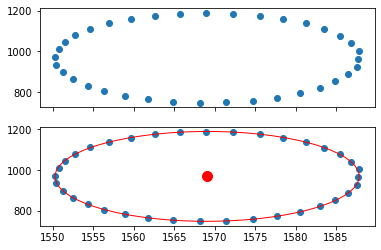

In [91]:
[e2,cog_allbeads]=identifyEllipses2(tcal,selem=disk(2))

In [92]:
len(e2) , len(cog_allbeads)

(36, 36)

In [93]:
#Removing the first 10 ellipse and beads entries to remove the outliers
n=10
del e2[0:3]
#del e2[24:]

In [94]:
del cog_allbeads[0:3]
#del cog_allbeads[24:]

# Estimate the magnification

[2.78245368 2.76949784 2.77828309]


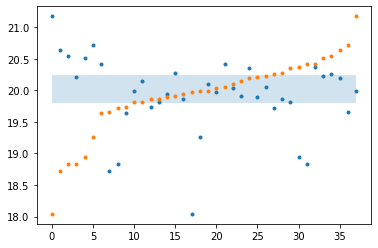

In [149]:
pixel_pitch=0.139
d=np.sort(np.diff(cog[:,0]))
m=d[6:-6].mean()
s=d[6:-6].std()
k=1
plt.plot(np.diff(cog[:,0]),'.')
plt.plot(d,'.')
plt.fill_between([0, 37],y1=[m-k*s,m-k*s],y2=[m+k*s,m+k*s],alpha=0.2)

print(pixel_pitch*np.array([m,d.mean(),np.median(d)]))

### Estimating COR and tilt about the center

[-1.40399595e-04  9.68999895e+02]


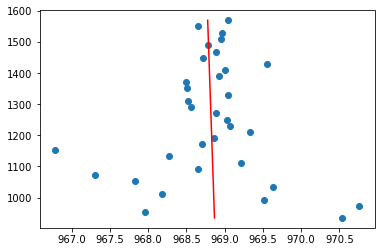

In [131]:
x_centres=[]
y_centres=[]
for i in range(len(e2)):
    x_centres.append(e2[i][1])
    y_centres.append(e2[i][0])
theta=np.polyfit(y_centres, x_centres, 1)
print(theta)
plt.scatter(x_centres,y_centres)
plt.plot(theta[1]+theta[0]*np.array(y_centres), y_centres, 'r')
plt.show()

In [32]:
print("The parameters of the COR obtained are as follows:",(theta[0], theta[1]))

The parameters of the COR obtained are as follows: (-0.0031261237353048437, 882.7113775389515)


#### Final value of COR can be obtained by subtractin the projection value taken 

In [150]:
tilt = np.arctan(theta[0])*180/np.pi
print("The tilt of the center of rotation is in degrees: ", tilt)

The tilt of the center of rotation is in degrees:  -0.008044304163329479


### Estimating Piercing Point

In [106]:
e2

[[934.8188813952617,
  970.5318328016093,
  4.072888676379167,
  215.68995247894378,
  0.00046669630173124167],
 [955.2792396220003,
  967.9627434760881,
  4.601483756064545,
  212.66029275243534,
  0.0004227382719271628],
 [973.9691310736348,
  970.7618424880608,
  210.50234526021265,
  5.061907067824218,
  1.5711191830346798],
 [992.9386389587362,
  969.5208452125345,
  219.5990310858603,
  5.302297828487232,
  1.5710214052938283],
 [1012.6744868649486,
  968.1840940192407,
  217.50806934383465,
  5.861223141911929,
  1.571064131246081],
 [1032.7385064893595,
  969.638638298044,
  6.351103158661907,
  216.79204691173692,
  0.0004907947848396682],
 [1052.7778797977219,
  967.826257014597,
  217.42750959512074,
  6.760036823240462,
  1.5711675802523628],
 [1072.4406172368633,
  967.3009051317517,
  7.23130012181769,
  216.3914558813138,
  0.0002994995677854201],
 [1092.343988288354,
  968.6576510298646,
  7.679542276531225,
  216.61335544500403,
  0.00021958908716215473],
 [1112.382834

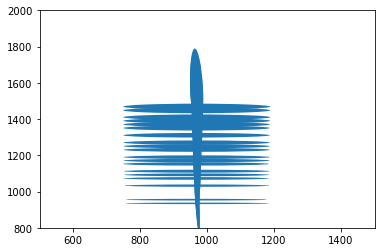

In [103]:
fig, ax = plt.subplots()

for idx in range(len(e2)):
    ellipse = Ellipse((e2[idx][1], e2[idx][0]), e2[idx][3]*2, e2[idx][2]*2, e2[idx][4])
    ax.add_artist(ellipse)


ax.set_xlim(500, 1500)
ax.set_ylim(800, 2000)

plt.show()

In [118]:
print(np.min([e2[0][2],e2[0][3]]))

4.072888676379167


In [119]:
radius=[]
height=[]
for i in range(len(e2)):
    radius.append(np.min([e2[i][2],e2[i][3]]))
    height.append(e2[i][0])
    
radius

[4.072888676379167,
 4.601483756064545,
 5.061907067824218,
 5.302297828487232,
 5.861223141911929,
 6.351103158661907,
 6.760036823240462,
 7.23130012181769,
 7.679542276531225,
 8.106592350659614,
 8.573385030395448,
 9.104956680254897,
 9.497209231763856,
 9.934436081914873,
 10.421642056003822,
 10.87874390104966,
 11.323817084925395,
 11.788731694857473,
 12.266832213778356,
 12.716731632608571,
 13.169360415069791,
 13.660074911246051,
 14.149988657974955,
 14.645120320564361,
 15.085943155045062,
 15.483229906976652,
 15.947431087141988,
 16.42589755060245,
 16.92297288171483,
 17.40940711497507,
 17.86040428250631,
 18.438468163239573,
 18.790926536768737]

Piercing point at 761.2328082713994


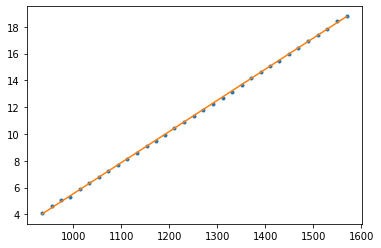

In [127]:
plt.plot(height,radius,'.')
theta=np.polyfit(height, radius, 1)
plt.plot(height,theta[0]*np.array(height)+theta[1])
print('Piercing point at {0}'.format(-theta[1]/theta[0]))

In [37]:
i = np.argmin(radius)
x_min = height[i]
y_min = e2[i][1]
print(x_min, y_min)

874.4250557042624 877.6308700086178


In [38]:
vpiercing= y_min
hpiercing= x_min

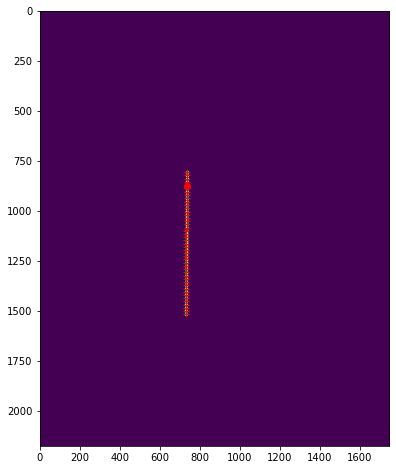

In [39]:
idx=21
c=2.5
cog=findBeadsWS(tcal[idx,:,:])

plt.figure(figsize=[12,8])
plt.imshow(tcal[idx,:,:])

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')
plt.plot(cog[10,1]-1,vpiercing,'ro')

### Estimating SOD and SDD

In [40]:
def estDistances(h,ha,hb,R) :
    H = np.array([[1,-h/ha], [1,-h/hb]])
    y = np.array([-R,R])
        
    est=np.linalg.solve(H,y)
    
    return est

In [41]:
pixelSize = 0.139
R = 10
c0=itemList(findBeadsWS(tcal[0,:,:]))
sod = []
sdd = [] 
for idx in range(np.array(e2).shape[0]) :
    ha=(e2[idx][0]-e2[idx][2]-vpiercing) * pixelSize
    hb=(e2[idx][0]+e2[idx][2]-vpiercing) * pixelSize
    h=0
    if idx in c0 :
        h = (c0[idx][0]-vpiercing)*pixelSize
    est_sod= (hb+ha)*R/(hb-ha)
    est_sdd= ((est_sod-R)*hb)/h
    sod.append(np.abs(est_sod))
    sdd.append(np.abs(est_sdd))
    print("h: {0:0.3f}, S0D: {1:0.2f}, SDD: {2:0.2f}, magn: {3:0.2f}".format(h,est_sod, est_sdd,est_sdd/est_sod))

sod = np.mean(sod)
sdd = np.mean(sdd)
            
print("Mean SOD= ", sod)
print("Mean SDD= ", sdd)
print("Magnification= ", sdd/sod)

h: -9.567, S0D: -9.14, SDD: 0.08, magn: -0.01
h: -7.193, S0D: 71.80, SDD: -41.37, magn: -0.58
h: -4.898, S0D: 106.04, SDD: -141.49, magn: -1.33
h: -2.630, S0D: 132.99, SDD: -449.72, magn: -3.38
h: -0.376, S0D: 151.39, SDD: -4528.65, magn: -29.91
h: 1.993, S0D: 166.10, SDD: 1132.94, magn: 6.82
h: 4.342, S0D: 183.99, SDD: 675.03, magn: 3.67
h: 6.713, S0D: 195.40, SDD: 531.93, magn: 2.72
h: 9.060, S0D: 207.58, SDD: 472.11, magn: 2.27
h: 11.388, S0D: 215.69, SDD: 430.66, magn: 2.00
h: 13.709, S0D: 223.84, SDD: 406.69, magn: 1.82
h: 16.055, S0D: 231.29, SDD: 391.39, magn: 1.69
h: 18.412, S0D: 237.48, SDD: 379.99, magn: 1.60
h: 20.764, S0D: 243.03, SDD: 371.54, magn: 1.53
h: 22.902, S0D: 248.86, SDD: 369.36, magn: 1.48
h: 25.073, S0D: 254.49, SDD: 368.07, magn: 1.45
h: 27.330, S0D: 257.71, SDD: 363.47, magn: 1.41
h: 29.623, S0D: 262.59, SDD: 362.15, magn: 1.38
h: 31.931, S0D: 266.84, SDD: 360.38, magn: 1.35
h: 34.171, S0D: 270.36, SDD: 357.93, magn: 1.32
h: 36.423, S0D: 272.47, SDD: 354.69, 

## Appendix - Extra Code snippets 

In [94]:
pixelSize = 0.139
R = 10
c0=itemList(findBeadsWS(tcal[0,:,:]))
sod = []
sdd = [] 


for idx in range(np.array(e2).shape[0]) :
    ha=(e2[idx][1]-e2[idx][2]-hpiercing) * pixelSize
    hb=(e2[idx][1]+e2[idx][2]-hpiercing) * pixelSize
    if idx in c0 :
        h = (c0[idx][0]-hpiercing)*pixelSize
        est = estDistances(h,ha,hb,R)
        sod.append(np.abs(est[0]))
        sdd.append(np.abs(est[1]))
        print("h: {0:0.3f}, S0D: {1:0.2f}, SDD: {2:0.2f}, magn: {3:0.2f}".format(h,est[0], est[1], est[1]/est[0]))

sod = np.mean(sod)
sdd = np.mean(sdd)
            
print("Mean SOD= ", sod)
print("Mean SDD= ", sdd)
print("Magnification= ", sdd/sod)

h: -199.867, S0D: -7.89, SDD: 1.80, magn: -0.23
h: -191.650, S0D: -7.91, SDD: 1.86, magn: -0.24
h: -182.066, S0D: -7.88, SDD: 2.00, magn: -0.25
h: -172.144, S0D: -7.89, SDD: 2.12, magn: -0.27
h: -162.393, S0D: -7.87, SDD: 2.28, magn: -0.29
h: -152.724, S0D: -7.87, SDD: 2.43, magn: -0.31
h: -142.959, S0D: -7.84, SDD: 2.64, magn: -0.34
h: -133.419, S0D: -7.84, SDD: 2.83, magn: -0.36
h: -123.974, S0D: -7.84, SDD: 3.06, magn: -0.39
h: -114.654, S0D: -7.87, SDD: 3.26, magn: -0.41
h: -104.871, S0D: -7.82, SDD: 3.68, magn: -0.47
h: -95.156, S0D: -34.25, SDD: -25.48, magn: 0.74
h: -85.333, S0D: -8.23, SDD: 3.59, magn: -0.44
h: -75.628, S0D: -8.24, SDD: 4.02, magn: -0.49
h: -65.864, S0D: -8.24, SDD: 4.65, magn: -0.56
h: -56.201, S0D: -8.21, SDD: 5.55, magn: -0.68
h: -46.491, S0D: -8.17, SDD: 6.86, magn: -0.84
h: -36.755, S0D: -8.16, SDD: 8.75, magn: -1.07
h: -26.997, S0D: -8.17, SDD: 11.85, magn: -1.45
h: -18.154, S0D: -26.76, SDD: -100.24, magn: 3.75
Mean SOD=  10.248284572287917
Mean SDD=  9.

In [ ]:
np.median(np.diff(cog[:,0]))

In [ ]:
cog=findBeadsWS(tcal[:,:,0])
d=medianDistance(cog)
idx=np.floor((cog[:,0]-cog[0,0])/d+0.5).astype(int)
    
idxList={}
for (i,c) in zip(idx,cog) :
    idxList[i]=c
    
print(idxList)

In [52]:
cog

array([[ 807.23857868,  737.20304569],
       [ 823.70149254,  736.98507463],
       [ 840.14948454,  737.25257732],
       [ 856.04950495,  736.62376238],
       [ 872.0776699 ,  736.5631068 ],
       [ 888.84541063,  736.57971014],
       [ 905.37931034,  736.46305419],
       [ 922.09615385,  736.29326923],
       [ 938.81339713,  736.25358852],
       [ 955.46464646,  735.94444444],
       [ 971.89423077,  735.96153846],
       [ 988.48275862,  735.71921182],
       [1005.1047619 ,  735.6047619 ],
       [1021.79      ,  735.45      ],
       [1036.93650794,  735.48148148],
       [1052.24870466,  735.20207254],
       [1068.33168317,  735.23762376],
       [1084.45      ,  735.09      ],
       [1100.50980392,  734.77941176],
       [1116.43902439,  734.67317073],
       [1132.5       ,  734.77227723],
       [1148.92890995,  734.46445498],
       [1165.27941176,  734.43627451],
       [1181.05524862,  734.29834254],
       [1195.9516129 ,  734.29032258],
       [1211.64356436,  7

In [61]:
distance = np.sqrt((cog[0][0]-cog[1][0])**2 + (cog[0][1]-cog[1][1])**2)
radius = distance/2
print("distance= ", distance)
print("magnification= ", distance/0.139)

distance=  16.464356776046333
magnification=  118.4486098996139
